# [Extra B] Tutorial 1 - Text Mining
## Transformer-based Language Model

- Nama: Muhammad Ichsanul Amal
- NPM: 1906353454

Tutorial ini merupakan tambahan untuk mereview beberapa teknik yang lebih baru untuk melakukan Text Mining. Pada bagian ini lebih berfokus pada Transformer-based Language Model. 

****
**KETERANGAN**

Bagian ini sudah termasuk dalam kategori *advanced* dan tidak wajib untuk diikuti. Notebook ini hanya untuk menunjukkan *state-of-the-art* (teknik terbaru) di ranah pengolahan bahasa (*Natural Language Processing*) dengan menggunakan *Machine Learning*.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers --quiet
!pip install --upgrade gdown --quiet

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 44.6 MB/s 
     |████████████████████████████████| 6.5 MB 32.0 MB/s 
     |████████████████████████████████| 895 kB 45.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
import numpy as np
import pandas as pd
import torch
import random
import gdown
import nltk

from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Kita akan menggunakan dataset yang sama seperti pada Tutorial sebelumnya, yaitu Deteksi Emosi pada Twitter Indonesia.

In [4]:
# TO DO: Upload dataset terlebih dahulu ke Colab
# Alternatifnya, file dataset bisa diunggah ke drive terlebih dahulu lalu lakukan 
# mounting drive ke Colab

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter_Emotion_Dataset.csv')
df.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


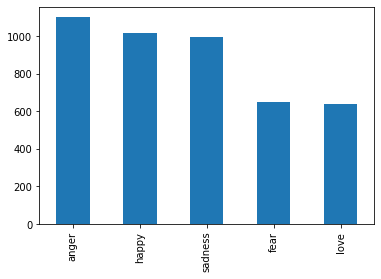

In [5]:
df['label'].value_counts().plot(kind='bar')

## Transformer-based Language Model

<img src="https://miro.medium.com/max/1838/1*iy12bH-FiUNOy9-0bULgSg.png" width=720/>

Transformer adalah salah satu model berbasis *deep neural network* dengan arsitektur *encoder-decoder* dan memanfaatkan mekanisme *self-attention*. Terdapat pembahasan yang lebih rinci mengenai model ini pada rujukan yang dicantumkan. 

Dalam konteks Natural Language Processing (NLP), model Transformer merupakan model Sequence-to-Sequence (Seq2Seq) di mana diberikan sebuah sequence kalimat atau paragraf, dan akan di-output berupa kalimat atau paragraf lain. Contoh use casenya adalah Machine Translation (penerjemah bahasa) atau Text Summarization (peringkasan teks). 

Pengembangan berikutnya adalah model BERT (Bidirectional Encoder Representations from Transformers). BERT memanfaatkan bagian encoder yang terdapat pada Transformer. 

Model ini memanfaatkan konsep transfer learning, di mana pertama model dilatih pada dataset berukuran besar untuk lebih memahami bahasa manusia secara umum. Berikutnya, model dilakukan fine-tuning untuk beberapa NLP *downstream task* yang spesifik, seperti klasifikasi sentimen, *question answering*, atau *Named-Entity Recognition*.

****

**[REQUIREMENTS]**

- Pastikan notebook Colab dijalankan dengan Runtime GPU. Untuk mengubahnya, buka menu "Runtime" > "Change runtime type". Ubah opsi Hardware Acceleration dari "None" menjadi "GPU". Notebook akan direstart dan Anda diminta untuk running cell dari awal.

****

Rujukan:
- Transformer Explained (https://towardsdatascience.com/transformers-explained-visually-not-just-how-but-why-they-work-so-well-d840bd61a9d3)
- BERT Explained (https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- (Paper Transformer): Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30. (https://proceedings.neurips.cc/paper/7181-attention-is-all-you-need)
- (Paper BERT): Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019, June). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4171-4186). (https://aclanthology.org/N19-1423/)

### 2a. Menggunakan Pre-Trained BERT

Untuk tutorial ini, kita menggunakan model `IndoBERTweet`. Model ini dikembangkan dari model `IndoBERT` yang sudah dilatih pada dataset teks Bahasa Indonesia sebagai model general-domain. Lalu model tersebut dilatih lagi pada dataset teks Twitter Indonesia dan menjadi model *domain-specific*.

****
Rujukan:
- (IndoBERT) Koto, F., Rahimi, A., Lau, J. H., & Baldwin, T. (2020, December). IndoLEM and IndoBERT: A Benchmark Dataset and Pre-trained Language Model for Indonesian NLP. In Proceedings of the 28th International Conference on Computational Linguistics (pp. 757-770). (https://aclanthology.org/2020.coling-main.66.pdf)
- (IndoBERTweet) Koto, F., Lau, J. H., & Baldwin, T. (2021, November). IndoBERTweet: A Pretrained Language Model for Indonesian Twitter with Effective Domain-Specific Vocabulary Initialization. In Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing (pp. 10660-10668). (https://aclanthology.org/2021.emnlp-main.833.pdf)

Untuk tutorial ini, library *deep learning* yang akan digunakan yaitu PyTorch. Library Transformers yang dirilis oleh https://huggingface.co lebih terintegrasi dengan PyTorch, namun tetap bisa juga menggunakan TensorFlow. 

Langkah pertama adalah mengatur Hyperparameter.

In [6]:
class Params():

  def __init__(self, model_name: str, tokenizer_name: str, 
               epochs=5, lr=3e-6, max_length=128, seed=2022,
               batch_size=32):

    self.model_name = model_name
    self.tokenizer_name = tokenizer_name
    self.epochs = epochs
    self.lr = lr
    self.max_length = max_length
    self.seed = seed
    self.batch_size = batch_size

PARAMS = Params(
    model_name = 'indolem/indobertweet-base-uncased',
    tokenizer_name = 'indolem/indobertweet-base-uncased'
)

In [7]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(PARAMS.seed)

Pada implementasinya, model BERT terdiri dari dua komponen, yaitu **Tokenizer** dan **Model**nya sendiri.

1. Tokenizer berperan untuk memetakan token-token yang muncul pada teks menjadi angka di *vocabulary*.

2. Model berperan untuk melakukan *machine-learning task* yang spesifik.



Sebagai contoh, berikut adalah contoh output dari tokenizer. Pertama, tokenizer akan memberikan token spesial yang menandakan awal dokumen [CLS], pembatas kalimat [SEP], dan padding [PAD]. 

Jika dilihat pada baris kedua, perhatikan pada kata "nyante". Tokenisasi yang dilakukan pada kata-kata yang tidak terdapat pada *vocabulary* di-*resolve* dengan cara dipecah menjadi bagian-bagian yang ada pada *vocabulary*. Dalam hal ini, kata "nyante" dipecah menjadi "nya", "nt", "e".  

In [8]:
tokenizer = BertTokenizer.from_pretrained(PARAMS.tokenizer_name)

example_text = 'Nyante dulu.. Sruput kopi biar tambah bijak...'
bert_input = tokenizer(example_text,padding='max_length', max_length = 20, 
                       truncation=True, return_tensors="pt")


print(tokenizer.decode(bert_input.input_ids[0]))
print("=================")
print(tokenizer.tokenize(example_text))
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

[CLS] nyante dulu.. sruput kopi biar tambah bijak... [SEP] [PAD] [PAD] [PAD]
['nya', '##nt', '##e', 'dulu', '.', '.', 'sr', '##uput', 'kopi', 'biar', 'tambah', 'bijak', '.', '.', '.']
tensor([[    3,  2647, 13231,   929,  3594,    18,    18,  7013, 18187,  6301,
          9421,  5937, 10946,    18,    18,    18,     4,     0,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])


### 2b. Dataset Preparation

Selanjutnya, kita akan menggunakan library dari PyTorch untuk membentuk dataset. Kegunaan dari pemetaan dataset PyTorch yaitu untuk mempermudah konversi ke framework PyTorch khususnya keitka melakukan *training*.

In [9]:
tokenizer = BertTokenizer.from_pretrained(PARAMS.model_name)
labels = {'anger':0,
          'happy':1,
          'sadness':2,
          'fear':3,
          'love':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = PARAMS.max_length, truncation=True,
                                return_tensors="pt") for text in df['tweet']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [10]:
# Splitting dataset

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=PARAMS.seed), 
                                     [int(.6*len(df)), int(.8*len(df))])

print(len(df_train),len(df_val), len(df_test))

2640 880 881


### 2c. Model Preparation

Selanjutnya, kita akan membangun model BERT untuk klasifikasi. Model Deep Learning umumnya dibangun dari beberapa *layer*. Untuk model BERT Classifier di sini, terdapat 2 layer secara keseluruhan:
1. BERT Layer: Layer ini merupakan arsitektur utama BERT. Dalam kasus ini, kita menggunakan layer yang sudah pre-trained di `IndoBERTweet`.
2. Dropout + Classifier Layer (Reduce): Layer ini berperan untuk memetakan output untuk keperluan klasifikasi. Pada kasus ini, terdapat lima label yang dipetakan. 

In [11]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(PARAMS.model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### 2d. Training Model

Selanjutnya kita akan melakukan training model. Pada kenyataannya, model BERT sudah bisa dibilang "terlatih" (pre-trained). Namun, kita akan melakukan *fine-tuning* untuk lebih menyesuaikan dengan konteks deteksi emosi.

In [12]:
def train(model, train_data, val_data, learning_rate, epochs, batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
model = BertClassifier()
              
train(model, df_train, df_val, PARAMS.lr, PARAMS.epochs, PARAMS.batch_size)

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 83/83 [01:43<00:00,  1.25s/it]


Epochs: 1 | Train Loss:  0.049                 | Train Accuracy:  0.299                 | Val Loss:  0.047                 | Val Accuracy:  0.381


100%|██████████| 83/83 [01:43<00:00,  1.25s/it]


Epochs: 2 | Train Loss:  0.045                 | Train Accuracy:  0.440                 | Val Loss:  0.043                 | Val Accuracy:  0.512


100%|██████████| 83/83 [01:43<00:00,  1.25s/it]


Epochs: 3 | Train Loss:  0.040                 | Train Accuracy:  0.549                 | Val Loss:  0.037                 | Val Accuracy:  0.610


100%|██████████| 83/83 [01:43<00:00,  1.25s/it]


Epochs: 4 | Train Loss:  0.033                 | Train Accuracy:  0.670                 | Val Loss:  0.031                 | Val Accuracy:  0.682


100%|██████████| 83/83 [01:43<00:00,  1.25s/it]


Epochs: 5 | Train Loss:  0.026                 | Train Accuracy:  0.759                 | Val Loss:  0.025                 | Val Accuracy:  0.749


### 2e. Evaluasi Model

Terakhir, kita coba lakukan evaluasi model. Berdasarkan evaluasi, kita bisa melihat skor yang lebih tinggi secara signifikan dibandingkan dengan Word2Vec maupun Unigram. 

In [13]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0

    y_pred = []
    y_test = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              y_pred = y_pred + output.argmax(dim=1).tolist()
              y_test = y_test + test_label.tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print("========================")
    print(classification_report(y_test, y_pred, 
                                target_names=sorted(labels, key=labels.get)))
    
evaluate(model, df_test)

Test Accuracy:  0.738
              precision    recall  f1-score   support

       anger       0.74      0.91      0.82       210
       happy       0.71      0.78      0.74       193
     sadness       0.69      0.54      0.61       233
        fear       0.88      0.68      0.76       124
        love       0.73      0.81      0.77       121

    accuracy                           0.74       881
   macro avg       0.75      0.74      0.74       881
weighted avg       0.74      0.74      0.73       881

